writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Modflow\MODFLOW2005\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS)

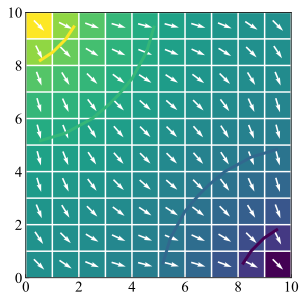

In [29]:
import os
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
[(0, 9, 9), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
budget_filerecord=budget_file,
head_filerecord=head_file,
saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv.plot_vector(qx, qy, normalize=True, color="white")

基于mf2005的稳定流模型

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Modflow\MODFLOW2005\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/27 23:12:08

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/27 23:12:08
 Elapsed run time:  0.021 Seconds

  Normal termination of simulation


d:\Users\81465\anaconda3\envs\flow\Lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


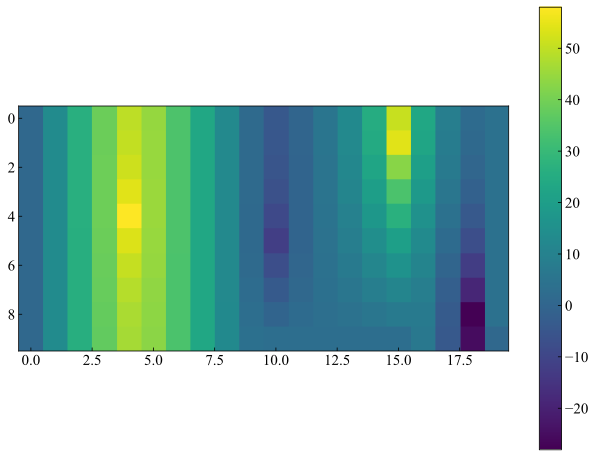

In [2]:
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
%config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
config = {
    'font.family':'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset':'stix',
    'savefig.dpi':300,}
plt.rcParams.update(config)

modelname = "my_model"
mf = flopy.modflow.Modflow(modelname, model_ws = './mymodel', exe_name = "mf2005")

Lx = 200.0
Ly = 100.0
ztop = 0.0
zbot = -10.0
nlay = 1
nrow = 10
ncol = 20
delr = Lx / nrow
delc = Ly / ncol
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1) 
# Discretization Input File (DIS)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = delr, delc = delc, top = ztop, botm = botm[1:])
# Basic Package (BAS)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[:,-1,10:16] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 1.0
strt[:, 0:9, -1] = 4.0
strt[:, -1, 10:16] = 3.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# Layer-Property Flow Package (LPF)
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:,:,0:5] = 10.0
hk[:,0:2,5:10] = 1.0
hk[:,2:7,5:10] = 5.0
hk[:,7:10,5:10] = 2.0
hk[:,:,10:20] = 8.0
lpf = flopy.modflow.ModflowLpf(mf, hk = hk, vka = 10.0, ipakcb=1)
# Well
spd = {0: [[0, 8, 18, -5000], [0, 4, 4, 4000], [0, 5, 10, -3000], [0, 1, 15, 6000] ]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data = spd)
# Output Control (OC)
spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
pcg = flopy.modflow.ModflowPcg(mf)
mf.write_input()
# run
success, buff = mf.run_model()
if not success:
    raise Exception("MODFLOW did not terminate normally.")

# hds = bf.HeadFile(modelname + ".hds")
hds = bf.HeadFile('./mymodel/' + modelname + ".hds")

head = hds.get_data(totim=1.0)

df = pd.DataFrame(head[0])
plt.figure(figsize=(11,8))
plt.imshow(df)
plt.colorbar()

基于mf2005的非稳定流模型

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Modflow\MODFLOW2005\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mymodel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/27 23:13:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress pe

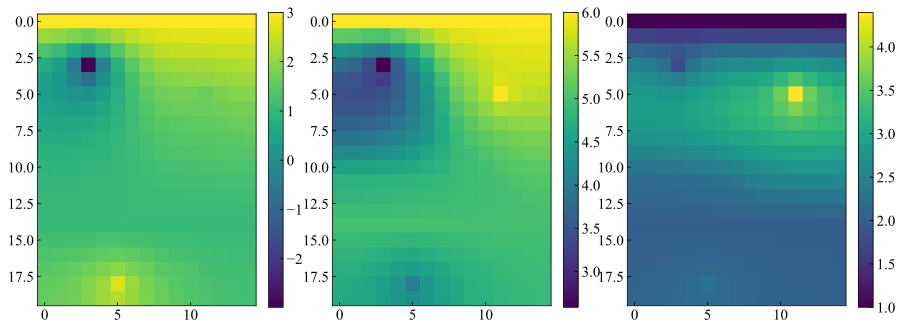

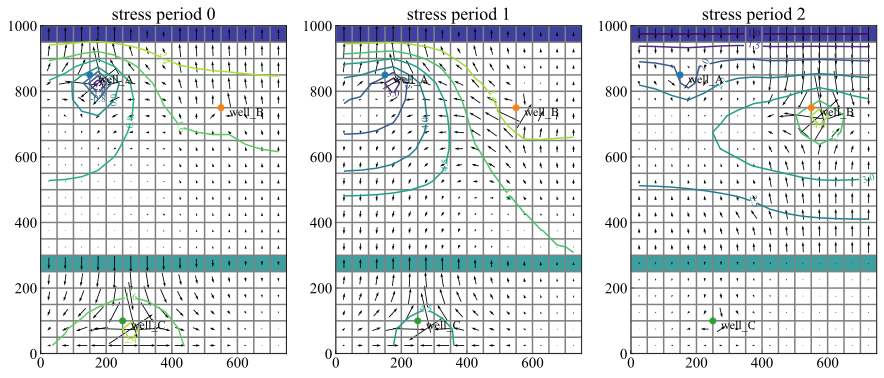

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# MODFLOW
mymodel = flopy.modflow.Modflow('mymodel', exe_name="mf2005", model_ws = './mymodel')
# DIS
Lx = 750.0                             # x 长度
Ly = 1000.0                            # y 长度 
ztop = 5.0                             # z 顶部高程
zbot = -50.0                           # z 底部高程
nlay = 1                               # 含水层层数
nrow = 20                              # 行数
ncol = 15                              # 列数
delc = Lx/ncol                           # x 步长
delr = Ly/nrow                           # y 步长
botm = np.linspace(ztop, zbot, nlay + 1) # z 每一层的底部高程
nper = 3
steady = [True, False, False]
perlen = [1, 100, 100]
nstp = [1, 100, 100]
dis = flopy.modflow.ModflowDis(mymodel, nlay, nrow, ncol, delr = delr,
                               delc = delc, top = ztop, botm = botm[1:], 
                               nper = nper, perlen = perlen, nstp = nstp, steady = steady)
# BAS
ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
strt = 10.0 * np.ones((nlay, nrow, ncol), dtype = np.float32)
bas = flopy.modflow.ModflowBas(mymodel, ibound = ibound, strt = strt)
# LPF
laytyp = 1   # 含水层类型
vka = 1.0    # 垂直渗透系数，单位：m/d
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)  # 水平渗透系数，单位：m/d
hk[:, 0:11, 0:8]  = 1.0
hk[:, 0:13, 8:16] = 3.0
hk[:, 11:21,0:8]  = 5.0
hk[:, 13:21,8:16] = 5.0
sy = 0.1     # 给水度，单位：1/m
ss = 1.e-4   # 单位储水量，单位：1/m
lpf = flopy.modflow.ModflowLpf(model = mymodel, hk = hk, vka = vka, sy = sy,
                               ss = ss, laytyp = laytyp, ipakcb = 1)
# CHD
# 应力周期 0
shead_0 = 3
ehead_0 = 3
bound_sp_0 = []     
# 应力周期 1
shead_1 = 3
ehead_1 = 6
bound_sp_1 = []
# 应力周期 2
shead_2 = 6
ehead_2 = 1
bound_sp_2 = []
for lay in range(nlay):
    for col in range(ncol):
        bound_sp_0.append([lay, 0, col, shead_0, shead_0])
        bound_sp_1.append([lay, 0, col, shead_1, ehead_1])
        bound_sp_2.append([lay, 0, col, shead_2, ehead_2])

chd_spd = {0: bound_sp_0, 1: bound_sp_1, 2: bound_sp_2}
chd = flopy.modflow.ModflowChd(model= mymodel, stress_period_data = chd_spd)
# WEL
wel_spd = {0: [[0, 3, 3, -500], [0, 5, 11, -100], [0, 18, 5,  600]],
           1: [[0, 3, 3, -200], [0, 5, 11,  200], [0, 18, 5, -350]],
           2: [[0, 3, 3, -100], [0, 5, 11,  500], [0, 18, 5,  100]]}
wel = flopy.modflow.ModflowWel(mymodel, stress_period_data = wel_spd)
# RIV
k_rivbott = 1 # 河床底部渗透系数，m/d
thick_rivbott = 1 # 河床沉积物厚度，m
cond = k_rivbott * (delr) * (delc) / (thick_rivbott) # conductance, m2/d
r_bott = 0 # 河底高程
riv_stage = [1, 5, 2] # 河流水位
riv_sp_0 = [] # 应力周期 0
riv_sp_1 = [] # 应力周期 1
riv_sp_2 = [] # 应力周期 2
for i in range(ncol):
    riv_sp_0.append([0, 14, i, riv_stage[0], cond, r_bott])
    riv_sp_1.append([0, 14, i, riv_stage[1], cond, r_bott])
    riv_sp_2.append([0, 14, i, riv_stage[2], cond, r_bott])
riv_spd = {0: riv_sp_0, 1: riv_sp_1, 2: riv_sp_2}
riv = flopy.modflow.ModflowRiv(model = mymodel, stress_period_data = riv_spd)
# OC
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(mymodel, stress_period_data = stress_period_data, compact = True)
# PCG
pcg = flopy.modflow.ModflowPcg(model = mymodel)
# RUN
mymodel.write_input()
success, mfoutput = mymodel.run_model(pause = False, report = True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

headobj = flopy.utils.binaryfile.HeadFile('./mymodel/mymodel' + ".hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile('./mymodel/mymodel' + ".cbc")
times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]]
head = {}
frf = {}
fff = {}
for stress_per, time in enumerate(times):
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time)
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time)
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time)
#########
# head
fig = plt.figure(figsize=(15, 45))
ax0 = fig.add_subplot(1, 3, 1)
im0 = ax0.imshow(head['sp0'][0])
plt.colorbar(im0, fraction = 0.06, pad = 0.05)
ax1 = fig.add_subplot(1, 3, 2)
im1 = ax1.imshow(head['sp1'][0])
plt.colorbar(im1, fraction = 0.06, pad = 0.05)
ax2 = fig.add_subplot(1, 3, 3)
im2 = ax2.imshow(head['sp2'][0])
plt.colorbar(im2, fraction = 0.06, pad = 0.05)
#########
# fd
fig = plt.figure(figsize = (15, 45))
mytimes = [perlen[0], perlen[0] + perlen[1], perlen[0] + perlen[1] + perlen[2]]
for iplot, time in enumerate(mytimes):
    head = headobj.get_data(totim = time)
    frf = budgobj.get_data(text = "FLOW RIGHT FACE", totim = time)[0]
    fff = budgobj.get_data(text = "FLOW FRONT FACE", totim = time)[0]
    
    ax = fig.add_subplot(1, len(mytimes), iplot + 1, aspect = "equal")
    ax.set_title("stress period " + str(iplot))
    
    pmv = flopy.plot.PlotMapView(model = mymodel, layer = 0, ax = ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid() # grid
    qm = pmv.plot_bc("CHD", alpha = 0.5)
    riv = pmv.plot_bc("RIV", alpha = 0.5)
    
    if head.min() != head.max():
        cs = pmv.contour_array(head)
        plt.clabel(cs, inline = 1, fontsize = 10, fmt = "%1.1f")
        quiver = pmv.plot_vector(frf, fff)
    # well  
    wpt0 = (150.0, 850.0)
    wpt1 = (550.0, 750.0)
    wpt2 = (250.0, 100.0)
    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(wpt0[0], wpt0[1], lw = 0, marker="o")
    ax.text(wpt0[0] + 25, wpt0[1] - 25, "well_A", size=12, zorder=12)
    ax.plot(wpt1[0], wpt1[1], lw = 0, marker="o")
    ax.text(wpt1[0] + 25, wpt1[1] - 25, "well_B", size=12, zorder=12)
    ax.plot(wpt2[0], wpt2[1], lw = 0, marker="o")
    ax.text(wpt2[0] + 25, wpt2[1] - 25, "well_C", size=12, zorder=12)

Solute transport model based on MT3DMS

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import flopy

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'stix',
    'savefig.dpi': 300,
})

# MODFLOW
mf = flopy.modflow.Modflow(modelname='mf', exe_name='mf2005.exe', model_ws='./mymodel')

# DIS
Lx, Ly = 1600, 2000
nrow, ncol, nlay = 40, 32, 1
delr = Lx / ncol
delc = Ly / nrow
ztop, zbot = 10, 0
botm = np.linspace(ztop, zbot, nlay + 1)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, 
                               botm=botm[1:], perlen=365, nstp=30, itmuni=4)

# BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
strt = 145 * np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[0, 0, :] = 250
strt[0, -1, :] = 36.25
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# LPF
laytyp = 0
hk = 12.7 * np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:, 10:18, 4:18] = 0.0127
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk, laytyp=laytyp, ipakcb=1)

# WEL
wel_spd = {0: [[0, 9, 15, 86.4], [0, 23, 15, -1633.0]]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

# OC
oc_spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True)

# PCG
pcg = flopy.modflow.ModflowPcg(mf)

# LMT
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

# Write MODFLOW inputs
mf.write_input()

# Run MODFLOW
success, mfoutput = mf.run_model()
if not success:
    raise Exception('MODFLOW did not terminate normally.')

# MT3DMS
mt = flopy.mt3d.Mt3dms(modelname='mt', version='mt3dms', exe_name='C:/path_to_executable/mt3dms5b.exe', 
                    modflowmodel=mf, model_ws='./mymodel')


# BTN
icbund = np.ones((nlay, nrow, ncol))
btn = flopy.mt3d.Mt3dBtn(mt, sconc=0, prsity=0.3, thkmin=0.01, tunit='D', munit='mg',
                         nprs=5, timprs=[0, 20, 60, 120, 360], icbund=icbund)

# ADV
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=1)

# DSP
dmcoef = 1.0e-9  # Placeholder value; adjust as needed
dsp = flopy.mt3d.Mt3dDsp(mt, al=20, dmcoef=dmcoef, trpt=0.2, trpv=0.01)

# SSM
ssm_data = {0: [(0, 9, 15, 57.87, 2)]}
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

# GCG
gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=1, iter1=50, isolve=1, cclose=0.0001)

# Write MT3D inputs
mt.write_input()
mt.run_model()
##########################
headobj = flopy.utils.binaryfile.HeadFile('./mymodel/mf' + ".hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile('./mymodel/mf' + ".cbc")
head = headobj.get_data()[0]
frf = budgobj.get_data(text='FLOW RIGHT FACE')[0]
fff = budgobj.get_data(text='FLOW FRONT FACE')[0]

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(1, 2, 1)
head_p = ax1.imshow(head)
plt.title('Head (m)')
plt.colorbar(head_p, fraction = 0.05, pad = 0.05)

ax2 = fig.add_subplot(1, 2, 2)
modelmap = flopy.plot.PlotMapView(model = mf, layer = 0)
grid = modelmap.plot_grid() 
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid() # grid
qm = modelmap.plot_bc("WEL", alpha = 0.5)
quiver = modelmap.plot_vector(frf, fff)
cs = modelmap.contour_array(head)
plt.clabel(cs, inline = 1, fmt = "%1.1f")
plt.title('Flow Direction')
##########################
conc = flopy.utils.UcnFile('./mymodel/MT3D001.UCN')
times = conc.get_times()
conc = conc.get_alldata()

fig = plt.figure(figsize=(15, 60))
ax = [i for i in range(10)]
for i in range(5):
    ax[i] = fig.add_subplot(1, 5, i + 1)
    ax[i].imshow(conc[i,0], cmap='Spectral_r') 

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Modflow\MODFLOW2005\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/27 23:42:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:

ValueError: An executable name or path must be provided

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy
sim_name = "my_mf6"     # 模型名称
length_units = "meters" # 长度单位
time_units = "seconds"  # 时间单位
# 加载数据
bottom = np.loadtxt(os.path.join("data", "bottom.txt"))
k11 = np.loadtxt(os.path.join("data", "hydraulic_conductivity.txt"))
idomain = np.loadtxt(os.path.join("data", "idomain.txt"), dtype=np.int32)
nper = 1       # 周期数
nlay = 1       # 含水层层数
nrow = 40      # 行数
ncol = 20      # 列数
delr = 250.0   # 列宽 (m)
delc = 250.0   # 行宽 (m)
top = 35.0     # 顶部高程 (m)
icelltype = 1  # 单元转换类型
strt = 45.0    # 初始水头 (m)
recharge = 1.60000000E-09  # 补给率 (m/s)
# 井边界条件
wel_spd = {
    0: [
        [0, 8, 15, -0.00820000],
        [0, 10, 12, -0.00410000],
        [0, 19, 13, -0.00390000],
        [0, 25, 9, -8.30000000E-04],
        [0, 28, 5, -7.20000000E-04],
        [0, 33, 11, -0.00430000],
       ]
}
# 定水头边界条件
chd_spd = {
    0: [
        [0, 39, 5, 16.90000000],
        [0, 39, 6, 16.40000000],
        [0, 39, 7, 16.10000000],
        [0, 39, 8, 15.60000000],
        [0, 39, 9, 15.10000000],
        [0, 39, 10, 14.00000000],
        [0, 39, 11, 13.00000000],
        [0, 39, 12, 12.50000000],
        [0, 39, 13, 12.00000000],
        [0, 39, 14, 11.40000000],
    ]
}
# 河流边界条件
rbot = np.linspace(20., 10.25, num = nrow)    # 河底底部高程
rstage = np.linspace(20.1, 11.25, num = nrow) # 河流水位
riv_spd = []
for idx, (s, b) in enumerate(zip(rstage, rbot)):
    riv_spd.append([0, idx, 14, s, 0.05, b])  # [层, 行, 列, 水位, 导水性, 底部高程]
riv_spd = {0: riv_spd}
sim_ws = os.path.join('model', sim_name)
sim = flopy.mf6.MFSimulation(sim_name = sim_name, sim_ws = sim_ws, exe_name = 'mf6')
delt = []
for stp in range(nstp):
    if stp == 0:
        if tsmult != 1.0:
            dt = perlen * (tsmult - 1) / ((tsmult ** nstp) - 1)
        else:
            dt = perlen / nstp
    else:
        dt = delt[-1] * tsmult
    delt.append(dt)
tdis_ds = [(1.0, 1, 1.0),]
flopy.mf6.ModflowTdis(sim, nper = nper, perioddata = tdis_ds, time_units = time_units)